In [1]:
import pickle
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
import sys
import os
import math
# import matplotlib as plt
import os.path
import matplotlib.pyplot as plt
import operator
import numpy as np
from astropy.stats import sigma_clip
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import astropy.io.fits as fits
import matplotlib.lines as lines
# from Luhman_Plot_View_Def import * 

In [3]:
def median_flux(ap_ph):
    ap_ph_med = ap_ph/np.nanmedian(ap_ph)
    return ap_ph_med
def receive_ascii_data(initial_time,dir_lightcurv,part_str,col):
    col_1='AperturePhot'
    col_2='bmjd'
    col_3='x_com_cen'
    col_4='y_com_cen'
    data = ascii.read(dir_lightcurv)
    ap_phot = data[col_1]
    bmjd = data[col_2]
    xcen=data[col_3]
    ycen=data[col_4]
    i_t =(bmjd-initial_time)*24
#     ap_phot=median_flux(ap_phot)## important to comment when you want to view all segments in line.
    plt.plot(i_t,ap_phot,'.',label=part_str,color=col)
    return(ap_phot,i_t,xcen,ycen)


def choose_fourier(nmode):
    def fourier_model(x,*fp):
        fourier = fp[1] ##setting the offset first.
#         print(fourier)
        for i in range(nmode):
            n=i+1
            fourier = fourier + fp[2+i*2]*np.cos(2.*np.pi*n*x/fp[0]) + fp[3+i*2]*np.sin(2.*np.pi*n*x/fp[0])
        return(fourier)
    return(fourier_model)

# def choose_fourier_jr(nmode, npoly):
#     def fourier_model(x,*fp):
#         a0_coeffs = fp[0:npoly+1]
#         fourier = np.polyval(a0_coeffs, x) ##setting the offset first.
# #       print(fourier)
#         for k in range(nmode):
#             n=k+1
#             an_coeffs = [npoly+1+(npoly+1)*2*k:npoly+(npoly+1)+1+(npoly+1)*2*k]
#             bn_coeffs = [npoly+1+(npoly+1)+n*2*(poly+1)*2**((k:npoly+npoly+1)*2+1+npoly+1)*2*k]
            
#             fourier = fourier + np.polyval(an_coeffs,x)*np.cos(2.*np.pi*n*x/fp[0]) + fp[3+i*2]*np.sin(2.*np.pi*n*x/fp[0])
#         return(fourier)
#     return(fourier_model)




def choose_ipsv(maxorder):
    def ipsv_model(xy_arr,*p):
        x=xy_arr[0,:]
        y=xy_arr[1,:]
        x_bar=np.mean(xy_arr[0,:])
        y_bar=np.mean(xy_arr[1,:])
        
        index_ipsv = 0
        ipsv = 1
        for i in range(maxorder):
            order=i+1
            loop_order=i+2
            for j in range(loop_order):
                ipsv=ipsv+p[index_ipsv]*(x-x_bar)**(order-j)*(y-y_bar)**(j)
                index_ipsv=index_ipsv+1
#         print(index_ipsv)
        return(ipsv)
    return(ipsv_model)


def choose_f_ipsv(nmodes,maxorder):
    def f_ipsv_model(xyt_arr,*p):
        x=xyt_arr[0,:]
        y=xyt_arr[1,:]
        t=xyt_arr[2,:]
        xy = np.array([x,y])
#       functions to find the number of parameters for each model.
        n_ipsv=0
        for i in range(maxorder):#parameters for ipsv
            n_ipsv = n_ipsv +(i+2) 
            
        n_f = (2+2*(nmodes)) #parameters for fourier
#         print(n_f,n_ipsv)
#       splitting up actual parameter ( p ) according to model (ipsv then fourier parameters)
        p_ipsv = p[0:n_ipsv]
        p_f = p[n_ipsv::]
#         print(p)
        ipsv_model = choose_ipsv(maxorder)(xy,*p_ipsv)
        f_model = choose_fourier(nmodes)(t,*p_f)
        model = ipsv_model *f_model
        return(model)
    return(f_ipsv_model)

def bin_funct(data_arr,nbin):
    data= data_arr.data
    bins=len(data)
    binned_data = [np.mean(data[i*nbin:i*nbin+nbin]) for i in range(1,bins//nbin+1)]
    return binned_data

def organize_data(lightcurve):
    data_num = ascii.read(lightcurve)
    #saves in all data into a table array
    col_1='AperturePhot';col_2='bmjd';col_3='x_com_cen';col_4='y_com_cen'
    ap_ph = data_num[col_1]
    bmjd = data_num[col_2]
    x_cen=data_num[col_3]
    y_cen=data_num[col_4]
#     arr=np.array([ap_ph,bmjd,x_cen,x_cen])    
    return(ap_ph,bmjd,x_cen,y_cen)

def clip_of_mask_flux(clip_flux):
    clip = sigma_clip(clip_flux, sigma=sigma_num, sigma_lower=None, sigma_upper=None, iters=5, cenfunc=np.ma.median, stdfunc=np.std, axis=None, copy=True)
    clipped = clip[np.logical_not(clip.mask)] - 1.
    return clipped

def clip_of_mask (clp_med_flux, x):
    clip = sigma_clip(clp_med_flux, sigma=sigma_num, sigma_lower=None, sigma_upper=None, iters=5, cenfunc=np.ma.median, stdfunc=np.std, axis=None, copy=True)
    clipped_x = x[np.logical_not(clip.mask)]
    return clipped_x  

def clip_arr(data,time,xcen,ycen,sigma):
    sigma_num = sigma
#     Calls previous definition functions and plots them
#     This is to make the code more neater.
    clip_flux = clip_of_mask(data,data)
    clip_time = clip_of_mask(data,time)
    clip_xcen = clip_of_mask(data,xcen)
    clip_ycen = clip_of_mask(data,ycen)
#     arr=np.array([clip_flux,clip_time,clip_xcen,clip_ycen]) 
    return (clip_flux,clip_time,clip_xcen,clip_ycen)

def median_flux(ap_ph_seg,full_LC):
    median_flux = np.nanmean(full_LC)
#     print(median_flux)
    ap_ph_med = ap_ph_seg/median_flux
    return ap_ph_med

def ExtArrFunct(x3,x5,x1,x4,x7,x2,x6_1):
    final_arr=[]
    ch1_arr=[]
    ch2_arr=[]
    final_arr.extend(x3);ch1_arr.extend(x3)
    final_arr.extend(x5);ch2_arr.extend(x5)
    final_arr.extend(x1);ch1_arr.extend(x1)
    final_arr.extend(x4);ch2_arr.extend(x4)
    final_arr.extend(x7);ch1_arr.extend(x7)
    final_arr.extend(x2);ch2_arr.extend(x2)
    final_arr.extend(x6_1);ch1_arr.extend(x6_1)
    Tot_arr_table = Column(final_arr, name='Column')#change its type from list to astropy column to mask data points
    ch1_arr_table = Column(ch1_arr, name='Column')
    ch2_arr_table = Column(ch2_arr, name='Column')
    return Tot_arr_table,ch1_arr_table,ch2_arr_table

# def ExtArrFunct(x3,x5,x1,x4,x7,x2,x6_1):
#     final_arr=[]
#     ch1_arrset1=[]
#     ch1_arrset2=[]
#     ch2_arr=[]
#     final_arr.extend(x3);ch1_arrset1.extend(x3)
#     final_arr.extend(x5);ch2_arr.extend(x5)
#     final_arr.extend(x1);ch1_arrset1.extend(x1)
#     final_arr.extend(x4);ch2_arr.extend(x4)
#     final_arr.extend(x7);ch1_arrset2.extend(x7)
#     final_arr.extend(x2);ch2_arr.extend(x2)
#     final_arr.extend(x6_1);ch1_arrset2.extend(x6_1)
#     Tot_arr_table = Column(final_arr, name='Column')#change its type from list to astropy column to mask data points
#     ch1_1_arr_table = Column(ch1_arrset1, name='Column')
#     ch1_2_arr_table = Column(ch1_arrset2, name='Column')
#     ch2_arr_table = Column(ch2_arr, name='Column')
#     return Tot_arr_table,ch1_1_arr_table,ch1_2_arr_table,ch2_arr_table


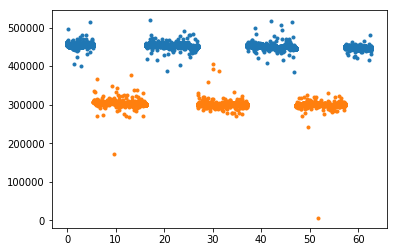

In [4]:
created_dir ='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com_test'
name_of_file_last = '/com_ap_ph_prt'
fileN= created_dir+name_of_file_last

lightcurve_1='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt1/bcdfits_com_part_1.txt'
lightcurve_2='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt2/bcdfits_com_part_2.txt'
lightcurve_3='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt3/bcdfits_com_part_3.txt'
lightcurve_4='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt4/bcdfits_com_part_4.txt'
lightcurve_5='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt5/bcdfits_com_part_5.txt'
lightcurve_6_1='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-1/bcdfits_com_part_6-1.txt'
lightcurve_6_2='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt6-2/bcdfits_com_part_6-2.txt'
lightcurve_7='/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/com_ap_ph_prt7/bcdfits_com_part_7.txt'

data = ascii.read(lightcurve_3)
bmjd = data['bmjd']
initial_time =bmjd[0]

# plt.figure(figsize=(8,6))
# plt.ylabel('Flux',fontsize = 13)
# plt.xlabel('Time (Hrs)',fontsize = 13)
# plt.title('Raw Light Curve',fontsize = 13)


ap_ph_1,bmjd_1,x_cen1,y_cen1= receive_ascii_data(initial_time,lightcurve_1,'Ch1 IRAC 3.6 microns','C0')
ap_ph_2,bmjd_2,x_cen2,y_cen2= receive_ascii_data(initial_time,lightcurve_2,'Ch2 IRAC 4.5 microns','C1')
# plt.legend(loc='lower right')
ap_ph_3,bmjd_3,x_cen3,y_cen3= receive_ascii_data(initial_time,lightcurve_3,'CH1 Part 3','C0')
ap_ph_4,bmjd_4,x_cen4,y_cen4= receive_ascii_data(initial_time,lightcurve_4,'CH2 Part 4','C1')
ap_ph_5,bmjd_5,x_cen5,y_cen5= receive_ascii_data(initial_time,lightcurve_5,'CH2 Part 5','C1')
ap_ph_6_1,bmjd_6_1,x_cen6_1,y_cen6_1= receive_ascii_data(initial_time,lightcurve_6_1,'CH1 Part 6-1','C0')
# ap_ph_6_2,bmjd_6_2,x_cen6_2,y_cen6_2= receive_ascii_data(lightcurve_6_2,'CH1 Part 6-2')
ap_ph_7,bmjd_7,x_cen7,y_cen7= receive_ascii_data(initial_time,lightcurve_7,'CH1 Part 7','C0')
# # -----------------------------------------------------------
# plt.legend(loc='lower right')
# legend(h);



# add="Raw_Light_curve.png"
# save_figure = "/Users/melaniapena/Desktop/"+add
# plt.savefig(save_figure,dpi=300)

In [5]:
import warnings
warnings.filterwarnings("ignore")

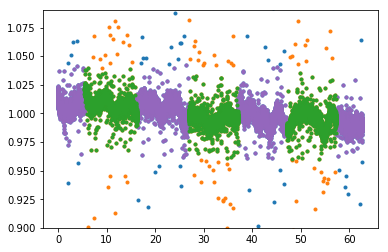

In [6]:
# -------------------------------------------------------------------------------------------------------------
#choose the mode and order for Fourier and IPSV polynomial
maxorder = 3; nmodes = 5; period = 12; sigma_num=5#nbin_num=63
# -------------------------------------------------------------------------------------------------------------
## Taking out the info from the the ASCII directory array.
## This also clips the data and takes the median of the flux array.

## trying to fit the whole Light curve at once.
ap_ph,ch1_ap_ph,ch2_ap_ph=ExtArrFunct(ap_ph_3,ap_ph_5,ap_ph_1,ap_ph_4,ap_ph_7,ap_ph_2,ap_ph_6_1)
hr,ch1_hr,ch2_hr=ExtArrFunct(bmjd_3,bmjd_5,bmjd_1,bmjd_4,bmjd_7,bmjd_2,bmjd_6_1)
xcen,ch1_xcen,ch2_xcen=ExtArrFunct(x_cen3,x_cen5,x_cen1,x_cen4,x_cen7,x_cen2,x_cen6_1)
ycen,ch1_ycen,ch2_ycen=ExtArrFunct(y_cen3,y_cen5,y_cen1,y_cen4,y_cen7,y_cen2,y_cen6_1)

ch1_ap_ph=median_flux(ch1_ap_ph,ch1_ap_ph)
ch2_ap_ph=median_flux(ch2_ap_ph,ch2_ap_ph)

plt.plot(ch1_hr,ch1_ap_ph,'.')
plt.plot(ch2_hr,ch2_ap_ph,'.')

c_f1,c_h1,c_xcen1,c_ycen1=clip_arr(ch1_ap_ph,ch1_hr,ch1_xcen,ch1_ycen,sigma_num)
c_f2,c_h2,c_xcen2,c_ycen2=clip_arr(ch2_ap_ph,ch2_hr,ch2_xcen,ch2_ycen,sigma_num)

plt.plot(c_h1,c_f1,'.',color='C4')
plt.plot(c_h2,c_f2,'.',color='C2')
plt.ylim(.90,1.09)
plt.show()

# # # -------------------------------------------------------------------------------------------------------------
# # fitting only Channel 1
# c_f=c_f1
# c_h=c_h1
# c_xcen=c_xcen1
# c_ycen=c_ycen1
# # -------------------------------------------------------------------------------------------------------------
# ### ONLY FOURIER MODEL (ASTROPHYSICAL MODEL)
# n_f = 2+2*(nmodes)
# print('Parameters for Fourier model: ',n_f) ## number of paramters for number of fourier terms
# # guess parameters for fourier
# guess_fourier = np.zeros(n_f)
# number = period
# period_guess=number/24
# offset_guess=1
# guess_fourier[0] = period_guess
# guess_fourier[1] = offset_guess
# # print(guess_fourier)

# # -------------------------------------------------------------------------------------------------------------
# ### ONLY IPSV MODEL
# n_ipsv=0
# for i in range(maxorder):
#     n_ipsv=n_ipsv +(i+2)
# print('Parameters for IPSV model: ',n_ipsv) ## number of parameters for ipsv polynomial
# # guess parameters for ipsv
# guess_ipsv = np.zeros(n_ipsv)
# xy_arr=np.array([c_xcen,c_ycen]) ##centroids in table array for curve fit
# # # -------------------------------------------------------------------------------------------------------------
# ### FULL MODEL (ASTROPHYSICAL AND IPSV MODEL)
# # Will be using the same guess parameters from ipsv and fourier
# guess_ipsv_f = np.append(guess_ipsv,guess_fourier)
# xyt_arr=np.array([c_xcen,c_ycen,c_h]) ### setting time, x centroid , and y centroid into the same table array.
# # Using the Curve fit for the model.
# full_params, covar = curve_fit(choose_f_ipsv(nmodes,maxorder),xyt_arr,c_f,p0=guess_ipsv_f)
# # # # # -------------------------------------------------------------------------------------------------------------
# ### Keeping the parameters consistent.
# fullp_ipsv = full_params[0:n_ipsv]
# fullp_f = full_params[n_ipsv::]

# model_f = choose_fourier(nmodes)(c_h,*fullp_f)
# model_ipsv = choose_ipsv(maxorder)(xy_arr,*fullp_ipsv)
# model_final = choose_f_ipsv(nmodes,maxorder)(xyt_arr,*full_params)
# print('Done')
# # # -------------------------------------------------------------------------------------------------------------
# plt.figure(figsize=(7,5))
# plt.plot(c_h,c_f,'.');plt.plot(c_h,model_ipsv,'.');plt.show() #To  see the full model over the clipped the flux.
# # plt.plot(c_f/model_ipsv,'.');plt.show() #see's that clipped flux divided out the ipsv.
# # plt.plot(model_final/model_ipsv);plt.show()#shows only the fourier part of the full model
# # plt.plot(model_final/model_f);plt.show() #shows only the ipsv part of the full model.
# # plt.plot(model_ipsv*model_f,'.');plt.plot(model_final,'.');plt.show() #compares the the two models together (both has same parameters)

In [7]:
# flux_w_no_ipsv = c_f/model_ipsv


# # data = ascii.read(lightcurve_3)
# # bmjd = data['bmjd']
# # initial_time =bmjd[0]
# # plt.figure(figsize=(7,5))
# # c_h1 = (c_h - initial_time)*24
# # # flux_med=median_flux(flux_w_no_ipsv)

# c_h1=c_h

# plt.title('Light Curve with IPSV Removed',fontsize=15)
# plt.xlabel('Time (Hrs)',fontsize=14)
# plt.ylabel('Flux',fontsize=14)
# plt.plot(c_h1,flux_w_no_ipsv,'.',label='Ch1 Light Curve');
# plt.legend(loc='upper right')
# # add="sec1_Raw_Light_curve.png"
# # save_figure = "/Users/melaniapena/Desktop/LC/"+add
# # plt.savefig(save_figure,dpi=600)
# plt.show()

NameError: name 'c_f' is not defined

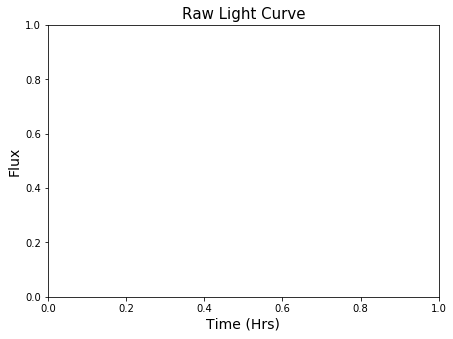

In [9]:
# print('Comparing the ipsv*f with final model with median:',np.nanmedian(model_f*model_ipsv/model_final))
# text ='Max Order: '+str(maxorder)+', '+str(n_ipsv)+' params \nModes: '+str(nmodes)+', '+str(n_f)+' params'+'\nPeriod: '+str(number)+' hrs'

# -----
# c_f = median_flux(c_f)
# model_final = median_flux(model_final)
# model_f = median_flux(model_f)
n=.970;m=1.015;o=2;sc=3
# -----


# n=440000;m=465000;
plt.figure(figsize=(7,5))
plt.title('Raw Light Curve',fontsize=15)
plt.xlabel('Time (Hrs)',fontsize=14)
plt.ylabel('Flux',fontsize=14)
# flux1_med=median_flux(c_f)
plt.plot(c_h1,c_f,'.',label=' Ch1 Raw Light Curve')
# plt.plot(c_h1,flux2_med,'.',label='IPSV * Fourier Model',color='coral')
# plt.xlim(o-sc,o+sc);
plt.legend(loc='upper right');
add="Sect_Raw_Light_curve.png"
save_figure = "/Users/melaniapena/Desktop/LC/"+add
plt.savefig(save_figure,dpi=600)
plt.show()


plt.figure(figsize=(7,5))
plt.title('Full Model of Light Curve',fontsize=15)
plt.xlabel('Time (Hrs)',fontsize=14)
plt.ylabel('Flux',fontsize=14)
plt.plot(c_h1,model_final,'.',label='IPSV * Fourier Model',color='coral')
# plt.ylim(n,m)
# plt.xlim(o-sc,o+sc);
plt.legend(loc='upper right');
# add="Full_Model_Lc.png"
# save_figure = "/Users/melaniapena/Desktop/LC/"+add
# plt.savefig(save_figure,dpi=600)
# plt.show()


# plt.title('model_ipsv*model_f with model_final')
# plt.plot(model_f*model_ipsv,color='coral')
# plt.plot(model_final,color='salmon')

plt.show()
plt.figure(figsize=(7,5))
plt.title('Fourier Series Model of Light Curve', fontsize = 15)
plt.xlabel('Time (Hrs)',fontsize=14)
plt.ylabel('Flux',fontsize=14)
# f_med = median_flux(model_f)
# ipsv_med = median_flux(model_ipsv)
plt.ylim(.99,1.01);
plt.xlim(o-sc,o+sc);
plt.plot(c_h1,model_f,'.',label='modes '+str(nmodes)+', '+str(n_f)+' parameters',color='orchid')
plt.ylim(n,m);
plt.legend(loc='upper right')
# add="Fourier_Model_Lc.png"
# save_figure = "/Users/melaniapena/Desktop/LC/"+add
# plt.savefig(save_figure,dpi=600)

plt.show()
plt.figure(figsize=(7,5))
plt.xlabel('Time (Hrs)',fontsize=14)
plt.ylabel('Flux',fontsize=14)
plt.title('Intrapixel Sensitivity Variation Model From Light Curve',fontsize=15)
plt.plot(c_h1,model_ipsv,'.',label='Max order '+str(maxorder)+', '+str(n_ipsv)+' parameters',color='orange')
plt.ylim(.975,1.025);
plt.xlim(o-sc,o+sc);
# plt.ylim(n,m);
plt.legend(loc='upper right')
# add="IPSV_Model_Lc.png"
# save_figure = "/Users/melaniapena/Desktop/LC/"+add
# plt.savefig(save_figure,dpi=600)
# plt.show()

# plt.figure(figsize=(7,5))

# print((ipsv_med*f_med)/flux2_med)

# plt.title('model_ipsv and model_f')
# plt.plot(c_f,'.',label='light curve');plt.xlim([-1000,20500])
# plt.plot(model_f,'.',label='nmodes '+str(nmodes)+', '+str(n_f)+' params',color='orchid')
# plt.plot(model_ipsv,'.',label='Max order '+str(maxorder)+', '+str(n_ipsv)+' params',color='orange')
# plt.legend(loc='upper right');plt.show()

In [42]:
# # Different format of same plots
# import numpy as np
# import matplotlib.pylab as plt
# import matplotlib.gridspec as gridspec
# gs = gridspec.GridSpec(2, 2)

# set_medf = median_flux(c_f)
# set_medmod = median_flux(model_final)
# set_medfo = median_flux(model_f)

# plt.figure(figsize=(13,13))

# ax = plt.subplot(gs[0, 0]) # row 0, col 0
# n=.97;m=1.025
# plt.ylim(n,m);
# plt.title('Astrophysical Model', fontsize = 12)
# plt.xlabel('Time (Hrs)',fontsize=10)
# plt.ylabel('Flux',fontsize=10)
# plt.plot(c_h1,set_medfo,'.',label='modes '+str(nmodes)+', '+str(n_f)+' parameters',color='orchid')
# # plt.legend(loc='upper right')

# ax = plt.subplot(gs[0, 1]) # row 0, col 1
# n=.97;m=1.025
# plt.ylim(n,m);
# plt.xlabel('Time (Hrs)',fontsize=10)
# plt.ylabel('Flux',fontsize=10)
# plt.title('Intrapixel Sensitivity Variation Model',fontsize=12)
# plt.plot(c_h1,model_ipsv,'.',label='Max order '+str(maxorder)+', '+str(n_ipsv)+' parameters',color='orange')
# # plt.legend(loc='upper right')

# ax = plt.subplot(gs[1, :]) # row 1, span all columns
# n=.97;m=1.025
# plt.ylim(n,m);
# plt.plot(c_h1,set_medf,'.',label='Raw Light Curve')
# plt.title('Full Model of Light Curve',fontsize=12)
# plt.xlabel('Time (Hrs)',fontsize=10)
# plt.ylabel('Flux',fontsize=10)
# plt.plot(c_h1,set_medmod,'.',label='IPSV * Astrophysical Model',color='coral')
# plt.legend(loc='upper right')
# save_figure = "/Users/melaniapena/Desktop/LC/model_plot1.png"
# plt.savefig(save_figure,dpi=300)



In [79]:
# flux_w_no_ipsv = c_f/model_ipsv
# med = median_flux(flux_w_no_ipsv)
# plt.figure(figsize=(8,5))
# plt.title('Light Curve with IPSV divided out.')
# plt.plot(c_h1,med,'.',label='Light curve with IPSV divided out.')
# plt.xlabel('Time (Hrs)',fontsize=10)
# plt.ylabel('Flux',fontsize=10)
# # plt.legend(loc='upper right');

# plt.show()
# # save_figure = "/Users/melaniapena/Desktop/lc_noIPSV.png"
# # plt.savefig(save_figure,dpi=600)

Std:  1090.3521625762562
Total Parameters: 17
Chi_Sqaured: 19045.224703806085
Length of Flux:  18556
Chi-Sqrd/len(Flux):  1.0263647717075923
BIC:  1.0353691544513903


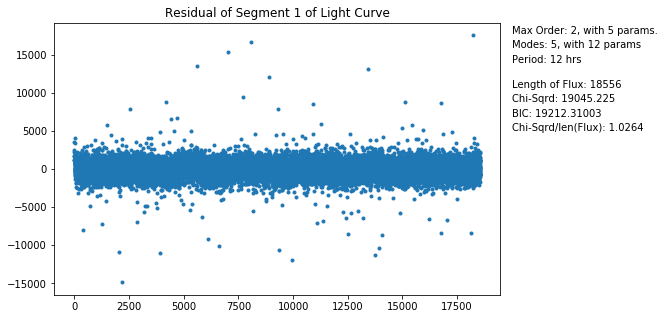

In [80]:
def chi_sqrd(Model, Data, unc):
    two = 2
    chi_squared = sum(((Data - Model) ** two) / unc ** two)
    return chi_squared

# This gives noise from the data
flux_roll = np.roll(c_f,1)
diff = flux_roll - c_f
f_stdev = np.std(diff) / np.sqrt(2)
print('Std: ',f_stdev) ## noise is for each data point 0.2%

chi_2 = chi_sqrd(model_final,c_f,f_stdev)
len_c_f = len(c_f)
chi_val = round(chi_2,3)
chi_div_len_fl = chi_2/(len(c_f))
round_chi_div_len_fl = round(chi_div_len_fl,4)

# The BIC formula:
total_param = n_ipsv+n_f
BIC = round(chi_2 + (np.log(len_c_f)*(total_param)),5)

plt.figure(figsize=(8,5))
print('Total Parameters:',total_param)
print('Chi_Sqaured:',chi_2)
print('Length of Flux: ',len(c_f))
print('Chi-Sqrd/len(Flux): ',chi_2/(len(c_f)))
print('BIC: ', BIC/(len(c_f)))
plt.title('Residual of Segment 1 of Light Curve')
str1 = 'Max Order: '+str(maxorder)+', with '+str(n_ipsv)+' params.'
str2 = 'Modes: '+str(nmodes)+', with '+str(n_f)+' params'
str3 = 'Period: '+str(number)+' hrs'
str4 = 'Chi-Sqrd: '+ str(chi_val)
str5 = 'Length of Flux: '+ str(len(c_f))
str6 = 'Chi-Sqrd/len(Flux): '+ str(round_chi_div_len_fl)
str7 = 'BIC: ' + str(BIC)
plt.figtext(0.92,0.85,str1)
plt.figtext(0.92,0.81,str2)
plt.figtext(0.92,0.77,str3)
plt.figtext(0.92,0.73-.03,str5)
plt.figtext(0.92,0.69-.03,str4)
plt.figtext(0.92,0.65-.03,str7)
plt.figtext(0.92,0.61-.03,str6)
res = c_f - model_final
plt.plot(res,'.',label='Light Curve')
# plt.legend(loc='upper right')
# save_figure = "/Users/melaniapena/Desktop/residual_plot.png"
# plt.savefig(save_figure,dpi=600)

In [ ]:
flux_w_no_ipsv = c_f/model_ipsv

# plt.title('full original flux');plt.plot(h,f,'.');plt.show()# original full flux with noise
# plt.title('clipped flux');plt.plot(c_h,c_f,'.');plt.show()# Uses the the sigma clip and clips out data points that are too far.
# plt.title('clipped flux with ipsv removed');plt.plot(c_h,flux_w_no_ipsv,'.');plt.show()#Clipped flux where they divide out the ipsv portion of the data and has already
# fitted the clipped.


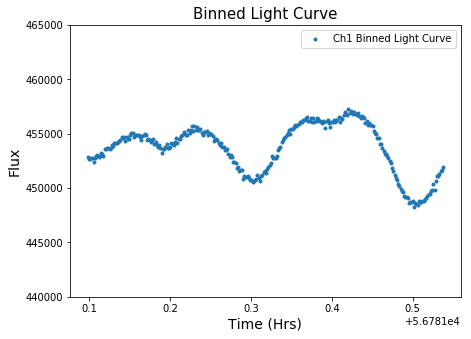

In [81]:
nbin_num=63
c_fbin = bin_funct(c_f,nbin_num);c_hbin = bin_funct(c_h1,nbin_num)
c_cenx_bin = bin_funct(c_xcen,nbin_num);c_ceny_bin = bin_funct(c_ycen,nbin_num)

n=440000;m=465000
# flux_w_no_ipsv
c_fbin_2 = bin_funct(flux_w_no_ipsv,nbin_num);c_hbin = bin_funct(c_h1,nbin_num)

# # ----
# c_fbin_2 = median_flux(c_fbin_2)
# # ----

# c_cenx_bin = bin_funct(c_xcen,nbin_num);c_ceny_bin = bin_funct(c_ycen,nbin_num)

# c_fbin_3 = bin_funct(flux_w_no_ipsv_2,nbin_num) #will be ignored for the time being.
# plt.plot(c_fbin,'.');plt.show()
plt.figure(figsize=(7,5))
plt.title('Binned Light Curve',fontsize=15)
plt.xlabel('Time (Hrs)',fontsize=14)
plt.ylabel('Flux',fontsize=14)

plt.ylim(n,m)
plt.plot(c_hbin,c_fbin_2,'.',label='Ch1 Binned Light Curve');plt.legend(loc='upper right');

add="binned_LC.png"
save_figure = "/Users/melaniapena/Desktop/LC/"+add
plt.savefig(save_figure,dpi=600)
plt.show()

# plt.plot(c_fbin_3,'.')##Will be ignored
# len(c_fbin_2)


In [ ]:
# if lightcurve == lightcurve_1: 
#     lightcurve = 'lightcurve_1'
# elif lightcurve == lightcurve_2:
#     lightcurve = 'lightcurve_2'
# elif lightcurve == lightcurve_3:
#     lightcurve = 'lightcurve_3'
# elif lightcurve == lightcurve_4:
#     lightcurve = 'lightcurve_4'
# elif lightcurve == lightcurve_5:
#     lightcurve = 'lightcurve_5'
# elif lightcurve == lightcurve_6_1:
#     lightcurve = 'lightcurve_6_1'
# elif lightcurve == lightcurve_7:
#     lightcurve = 'lightcurve_7'
# pickle_file= '/Users/melaniapena/Rsrch/Luhman_16_Research/ap_phot_ascii_com/pickle_LC/'
# if not os.path.exists(pickle_file):
#     os.makedirs(pickle_file)
# dir_pickle =pickle_file+'pickle_'+lightcurve+'.pickle'
# with open(dir_pickle, 'wb') as f:
#     pickle.dump([c_fbin_2,c_hbin,c_cenx_bin,c_ceny_bin], f)    